# Work with Text and Images

You need to run in the terminal:
```bash
pip install matplotlib
```

```bash
pip install -U torch torchvision
pip install -U "transformers>=4.41.0"
pip install -U qwen-vl-utils
pip install -U pillow
```


# Setup

In [2]:
import os
import io
import shutil
import base64

import matplotlib.pyplot as plt

from conversational_toolkit.chunking.pdf_chunker import PDFChunker

from conversational_toolkit.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)
from conversational_toolkit.embeddings.clip import CLIPEmbeddings
from conversational_toolkit.embeddings.qwen_vl import Qwen3VLEmbeddings
from conversational_toolkit.vectorstores.chromadb import ChromaDBVectorStore
from conversational_toolkit.retriever.vectorstore_retriever import (
    CompositeVectorStoreRetriever,
)

from conversational_toolkit.llms.base import LLMMessage, MessageContent, Roles
from conversational_toolkit.llms.openai import OpenAILLM

from conversational_toolkit.agents.base import QueryWithContext
from conversational_toolkit.agents.rag import RAG

Consider using the pymupdf_layout package for a greatly improved page layout analysis.


c:\Users\sieverin\SDSC\Code\sme-kt-zh-collaboration-rag\rag_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Parse document and chunk

In [3]:
chunker = PDFChunker()

In [4]:
chunks = chunker.make_chunks(
    "../../data/EPD_cardboard_redbox_cartonpallet.pdf",
    write_images=True,
    image_path="../../data/tmp_images/",
)

Chunk 0: # **Environmental Product Declaration** (text/markdown)
Chunk 1: #### In accordance with ISO 14025:2006 for: (text/markdown)
Chunk 2: ## **CARDBOARD BOX CARTONPALLET CMP** **ROSERIO** (text/markdown)
Chunk 3: ## **REDBOX Srl** (text/markdown)
Chunk 4: ### **Company information** (text/markdown)
Chunk 5: ### **Product information** (text/markdown)
Chunk 6: ### **LCA information** (text/markdown)
Chunk 7: ### **Content declaration** (text/markdown)
Chunk 8: ### **Results of the environmental performance indicators** (text/markdown)
Chunk 9: ### **Additional environmental information** (text/markdown)
Chunk 10: ### **References** (text/markdown)
Chunk 11: EPD_cardboard_redbox_cartonpallet.pdf-0-0.png (image/png)
Chunk 12: EPD_cardboard_redbox_cartonpallet.pdf-0-1.png (image/png)
Chunk 13: EPD_cardboard_redbox_cartonpallet.pdf-1-1.png (image/png)
Chunk 14: EPD_cardboard_redbox_cartonpallet.pdf-4-1.png (image/png)
Chunk 15: EPD_cardboard_redbox_cartonpallet.pdf-5-1.png (image/png)


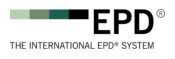

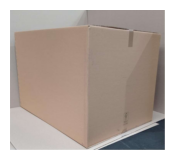

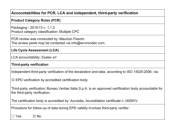

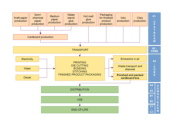

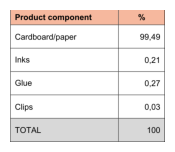

In [5]:
for i, chunk in enumerate(chunks):
    print(f"Chunk {i}: {chunk.title} ({chunk.mime_type})")
    if chunk.mime_type.startswith("image/"):
        image_data = base64.b64decode(chunk.content)

        image = plt.imread(io.BytesIO(image_data), format=chunk.mime_type.split("/")[1])

        plt.figure(figsize=(2, 2))
        plt.imshow(image)
        plt.axis("off")

plt.show()

# Embed Text

In [6]:
text_embedding_model = SentenceTransformerEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

if os.path.exists("../../db/db_text_tmp/"):
    shutil.rmtree("../../db/db_text_tmp/")
text_vector_store = ChromaDBVectorStore(db_path="../../db/db_text_tmp/")

text_chunks = [c for c in chunks if c.mime_type.startswith("text/")]

embeddings = await text_embedding_model.get_embeddings([c.content for c in text_chunks])

await text_vector_store.insert_chunks(chunks=text_chunks, embedding=embeddings)

print(sum(len(e) for e in embeddings))

2026-02-25 11:46:19.896 | DEBUG    | conversational_toolkit.embeddings.sentence_transformer:__init__:57 - Sentence Transformer embeddings model loaded: sentence-transformers/all-MiniLM-L6-v2 with kwargs: {}
2026-02-25 11:46:20.756 | DEBUG    | conversational_toolkit.embeddings.sentence_transformer:get_embeddings:76 - sentence-transformers/all-MiniLM-L6-v2 embeddings size: (11, 384)


4224


In [7]:
query = "What is the amount of PBT/vPvB substances ?"

query_embedding = await text_embedding_model.get_embeddings(query)

results = await text_vector_store.get_chunks_by_embedding(query_embedding, top_k=5)

print(len(results))

for i, result in enumerate(results):
    print(f"Result {i}: {result.title} ({result.mime_type})")

print(results[0].content)

2026-02-25 11:46:20.892 | DEBUG    | conversational_toolkit.embeddings.sentence_transformer:get_embeddings:76 - sentence-transformers/all-MiniLM-L6-v2 embeddings size: (1, 384)


5
Result 0: ### **Product information** (text/markdown)
Result 1: #### In accordance with ISO 14025:2006 for: (text/markdown)
Result 2: ### **Additional environmental information** (text/markdown)
Result 3: ### **Content declaration** (text/markdown)
Result 4: ### **Company information** (text/markdown)
### **Product information**

Product name: Cartonpallet CMP Roserio

Product description and identification: The product is a corrugated cardboard box (2 waves), printed, glued and stapled, measuring 1180x790x772 mm.

UN CPC code: 32153 “Cartons, boxes, cases, record sleeves and other packing containers (except bags) of paper, paperboard, cellulose wadding or webs of cellulose fibres; box files, letter trays, and similar articles, of paper or paperboard of a kind used in offices, shops or the like”

The product does not contain PBT/vPvB substances ≥ 0.1% evaluated in accordance with Annex XIII of REACH and does not contain any substances listed on the REACH candidate list.

Geographical

# Embed Images

In [8]:
# image_embedding_model = CLIPEmbeddings()
image_embedding_model = Qwen3VLEmbeddings()

if os.path.exists("../../db/db_image_tmp/"):
    shutil.rmtree("../../db/db_image_tmp/")

image_vector_store = ChromaDBVectorStore(db_path="../../db/db_image_tmp/")

image_chunks = [c for c in chunks if c.mime_type.startswith("image/")]

embeddings = await image_embedding_model.get_embeddings([c for c in image_chunks])

await image_vector_store.insert_chunks(chunks=image_chunks, embedding=embeddings)

print(sum(len(e) for e in embeddings))

10240


Result 0: EPD_cardboard_redbox_cartonpallet.pdf-0-1.png (image/png)
Result 1: EPD_cardboard_redbox_cartonpallet.pdf-4-1.png (image/png)
Result 2: EPD_cardboard_redbox_cartonpallet.pdf-0-0.png (image/png)
Result 3: EPD_cardboard_redbox_cartonpallet.pdf-1-1.png (image/png)
Result 4: EPD_cardboard_redbox_cartonpallet.pdf-5-1.png (image/png)


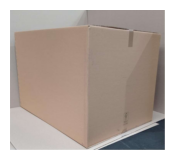

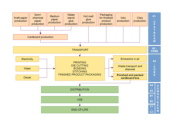

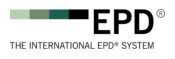

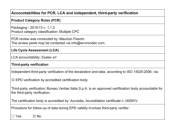

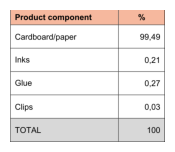

In [9]:
query = "A carboard box on a pallet"

query_embedding = await image_embedding_model.get_text_embeddings(query)

results = await image_vector_store.get_chunks_by_embedding(query_embedding, top_k=5)

for i, result in enumerate(results):
    print(f"Result {i}: {result.title} ({result.mime_type})")
    image_data = base64.b64decode(result.content)

    image = plt.imread(io.BytesIO(image_data), format=result.mime_type.split("/")[1])

    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.axis("off")

# Create Composite Vector Store

2026-02-25 11:47:06.568 | DEBUG    | conversational_toolkit.embeddings.sentence_transformer:get_embeddings:76 - sentence-transformers/all-MiniLM-L6-v2 embeddings size: (1, 384)


Result 0 - type: text/markdown
### **Product information**

Product name: Cartonpallet CMP Roserio

Product description and identification: The product is a corrugated cardboard box (2 waves), printed, glued and stapled, measuring 1180x790x772 mm.

UN CPC code: 32153 “Cartons, boxes, cases, record sleeves and other packing containers (except bags) of paper, paperboard, cellulose wadding or webs of cellulose fibres; box files, letter trays, and similar articles, of paper or paperboard of a kind used in offices, shops or the like”

The product does not contain PBT/vPvB substances ≥ 0.1% evaluated in accordance with Annex XIII of REACH and does not contain any substances listed on the REACH candidate list.

Geographical scope: Italy


Result 1 - type: text/markdown
#### In accordance with ISO 14025:2006 for:


Result 2 - type: text/markdown
### **Additional environmental information**

No further information is provided. This document is the first emission of EPD.

 PAGE 8/10

 
Result 3 

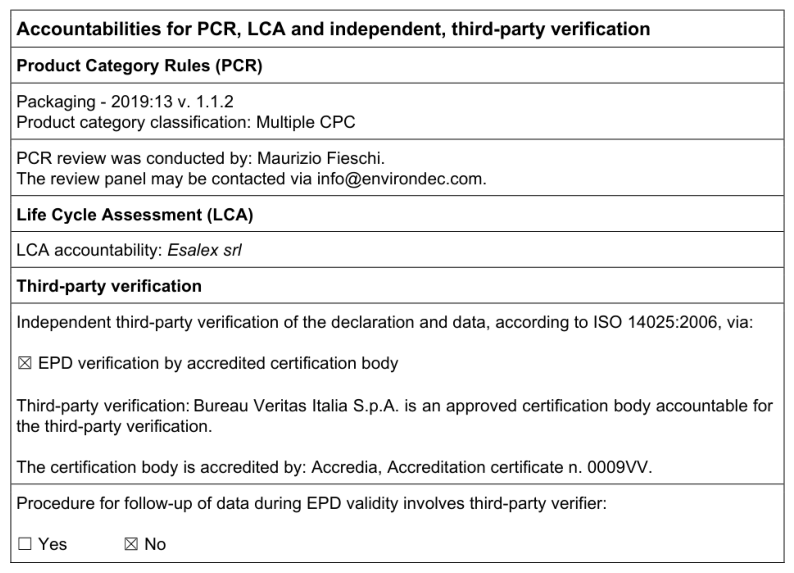

In [10]:
query = "What is the amount of PBT/vPvB substances ?"

composite_retriever = CompositeVectorStoreRetriever(
    embedding_models=[text_embedding_model, image_embedding_model],
    vector_stores=[text_vector_store, image_vector_store],
    top_k=[3, 1],
)

results = await composite_retriever.retrieve(query)

for i, result in enumerate(results):
    # if text print it
    print(f"Result {i} - type: {result.mime_type}")

    if result.mime_type.startswith("text/"):
        print(result.content)
    elif result.mime_type.startswith("image/"):
        image_data = base64.b64decode(result.content)

        image = plt.imread(
            io.BytesIO(image_data), format=result.mime_type.split("/")[1]
        )

        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis("off")

# Send Image to LLM

2026-02-25 11:47:08.030 | DEBUG    | conversational_toolkit.llms.openai:__init__:90 - OpenAI LLM loaded: gpt-4o-mini; temperature: 0.5; seed: 42; tools: None; tool_choice: None; response_format: {'type': 'text'}


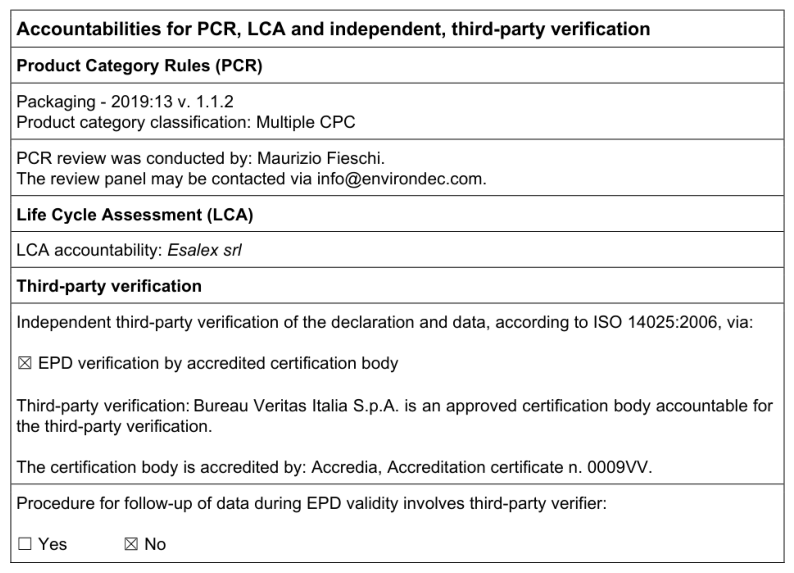

In [11]:
llm = OpenAILLM()

image_as_base64 = results[-1].content
image_data = base64.b64decode(image_as_base64)
image = plt.imread(io.BytesIO(image_data), format=results[-1].mime_type.split("/")[1])
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

In [12]:
test_messages = [
    LLMMessage(
        content=[
            MessageContent(
                type="input_text",
                text="What is in this image?",
            ),
            MessageContent(
                type="input_image",
                image_url=image_as_base64,
            ),
        ],
        role=Roles.USER,
    ),
]

In [13]:
answer = await llm.generate(test_messages)

print("\n\nAnswer content:")
print(answer.content)

2026-02-25 11:47:16.588 | DEBUG    | conversational_toolkit.llms.openai:generate:122 - Completion: ChatCompletion(id='chatcmpl-DD6iATPzrkCrnTtO6xlAGR28qTxVt', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The image contains a document outlining accountabilities related to Product Category Rules (PCR), Life Cycle Assessment (LCA), and third-party verification. Key points include:\n\n1. **Product Category Rules (PCR)**: Details about packaging standards and classification.\n2. **Life Cycle Assessment (LCA)**: Accountability attributed to a specific organization (Esalex srl).\n3. **Third-party Verification**: Information on independent verification processes, mentioning ISO standards and the accredited certification body (Bureau Veritas Italia S.p.A.) responsible for the verification.\n\nIt also includes a section regarding follow-up procedures for data validity during Environmental Product Declaration (EPD) verification.', refusal=No



Answer content:
[MessageContent(type='text', text='The image contains a document outlining accountabilities related to Product Category Rules (PCR), Life Cycle Assessment (LCA), and third-party verification. Key points include:\n\n1. **Product Category Rules (PCR)**: Details about packaging standards and classification.\n2. **Life Cycle Assessment (LCA)**: Accountability attributed to a specific organization (Esalex srl).\n3. **Third-party Verification**: Information on independent verification processes, mentioning ISO standards and the accredited certification body (Bureau Veritas Italia S.p.A.) responsible for the verification.\n\nIt also includes a section regarding follow-up procedures for data validity during Environmental Product Declaration (EPD) verification.', image_url=None)]


In [14]:
answer_stream = llm.generate_stream(test_messages)

result = ""
async for chunk in answer_stream:
    result += chunk.content[0].text if chunk.content else ""

print("\n\nAnswer content:")
print(result)



Answer content:
The image contains a document outlining accountabilities related to Product Category Rules (PCR), Life Cycle Assessment (LCA), and third-party verification. Key points include:

1. **Product Category Rules (PCR)**: Details about packaging standards and classification.
2. **Life Cycle Assessment (LCA)**: Accountability attributed to a specific organization (Esalex srl).
3. **Third-party Verification**: Information on independent verification processes, mentioning ISO standards and the accredited certification body (Bureau Veritas Italia S.p.A.) responsible for the verification.

It also includes a section regarding follow-up procedures for data validity related to Environmental Product Declarations (EPD).


# RAG

In [15]:
system_prompt = "You are a helpful assistant for answering questions about the content of documents. Use the following retrieved chunks to answer the question as best as you can. If you don't know the answer, say you don't know. Always use all available information from the retrieved chunks to provide a comprehensive answer."

agent = RAG(
    llm=llm,
    utility_llm=llm,
    system_prompt=system_prompt,
    retrievers=[composite_retriever],
    number_query_expansion=0,
)

2026-02-25 11:47:20.058 | DEBUG    | conversational_toolkit.embeddings.sentence_transformer:get_embeddings:76 - sentence-transformers/all-MiniLM-L6-v2 embeddings size: (1, 384)



 The product does not contain PBT/vPvB substances ≥ 0.1%.

The image features the logo of the International EPD® System.

Sources:
- ### **Product information** (text/markdown)
### **Product information**

Product name: Cartonpallet CMP Roserio

Product description and identification: The product is a corrugated cardboard box (2 waves), printed, glued and stapled, measuring 1180x790x772 mm.

UN CPC code: 32153 “Cartons, boxes, cases, record sleeves and other packing containers (except bags) of paper, paperboard, cellulose wadding or webs of cellulose fibres; box files, letter trays, and similar articles, of paper or paperboard of a kind used in offices, shops or the like”

The product does not contain PBT/vPvB substances ≥ 0.1% evaluated in accordance with Annex XIII of REACH and does not contain any substances listed on the REACH candidate list.

Geographical scope: Italy


- #### In accordance with ISO 14025:2006 for: (text/markdown)
#### In accordance with ISO 14025:2006 for:


- #

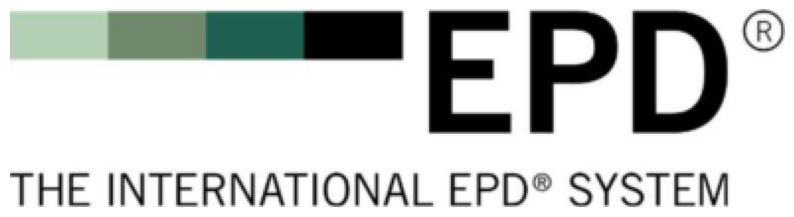

In [16]:
query = "What is the amount of PBT/vPvB substances? And describe the image. Short answer for both."
query_with_context = QueryWithContext(query=query, history=[])

response = await agent.answer(query_with_context)

print("\n", response.content[0].text)

print("\nSources:")
for source in response.sources:
    print(f"- {source.title} ({source.mime_type})")
    if source.mime_type.startswith("text/"):
        print(source.content)
    elif source.mime_type.startswith("image/"):
        image_data = base64.b64decode(source.content)

        image = plt.imread(
            io.BytesIO(image_data), format=source.mime_type.split("/")[1]
        )

        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis("off")

----------------------